# TKO_7092 Evaluation of Machine Learning Methods 2024

---

Student name: Aleksi Pikkarainen

Student number: 519153

Student email: akpikk@utu.fi

---

## Exercise 4

Complete the tasks given to you in the letter below. In your submission, explain clearly, precisely, and comprehensively why the cross-validation described in the letter failed, how cross-validation should be performed in the given scenario and why  your cross-validation will give a reliable estimate of the generalisation performance. Then implement the correct cross-validation for the scenario and report its results.

Remember to follow all the general exercise guidelines that are stated in Moodle. Full points (2p) will be given for a submission that demonstrates a deep understanding of cross-validation on pair-input data and implements the requested cross-validation correctly (incl. reporting the results). Partial points (1p) will be given if there are small error(s) but the overall approach is correct. No points will be given if there are significant error(s).

The deadline of this exercise is **Wednesday 21 February 2024 at 11:59 PM**. Please contact Juho Heimonen (juaheim@utu.fi) if you have any questions about this exercise.

---


Dear Data Scientist,

I have a long-term research project regarding a specific set of proteins. Currently I am attempting to discover small organic compounds that can bind strongly to these proteins and thus act as drugs. I have a list of over 100.000 potential drug molecules, but their affinities still need to be verified in the lab. Obviously I do not have the resources to measure all the possible drug-target pairs, so I need to prioritise. I have decided to do this with the use of machine learning, but I have encountered a problem.

Here is what I have done so far: First I trained a K-nearest neighbours regressor with the parameter value K=10 using all the 400 measurements I had made in the lab, which comprise of all the 77 target proteins of interest but only 59 different drug molecules. Then I performed a leave-one-out cross-validation with this same data to estimate the generalisation performance of the model. I used C-index and got a stellar score above 90%. Finally I used the model to predict the affinities of the remaining drug molecules. The problem is: when I selected the highest predicted affinities and tried to verify them in the lab, I found that many of them are much lower in reality. My model clearly does not work despite the high cross-validation score.

Please explain why my estimation failed and how leave-one-out cross-validation should be performed to get a reliable estimate. Also, implement the correct leave-one-out cross-validation and report its results. I need to know whether I am wasting my lab resources by using my model.

The data I used to create my model is available in the files `input.data`, `output.data` and `pairs.data` for you to use. The first file contains the features of the pairs, whereas the second contains their affinities. The third file contains the identifiers of the drug and target molecules of which the pairs are composed. The files are paired, i.e. the i<sup>*th*</sup> row in each file is about the same pair.

Looking forward to hearing from you soon.

Yours sincerely, \
Bio Scientist

---

#### Answer the questions about cross-validation on pair-input data

In [1]:
# Why did the estimation described in the letter fail?

# >The bio scientist performed the LOOCV with all of his data without splitting it into training and test data. This causes overfitting and when
# he tries to do this with unseen data the accuracy plummets.

# How should leave-one-out cross-validation be performed in the given scenario and why?

# >The data should be split into training and test sets. I think GroupKFold would be a good fit as we can group with the 57 different drugs to more accurate-
# measure their independent performance.

# Remember to provide comprehensive and precise arguments.

#### Import libraries

In [6]:
# Import the libraries you need.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.neighbors import KNeighborsRegressor

#### Write utility functions

In [7]:
# Write the utility functions you need in your analysis.
def cindex(y, yp):
    n = 0
    h_num = 0 
    for i in range(0, len(y)):
        t = y[i]
        p = yp[i]
        for j in range(i+1, len(y)):
            nt = y[j]
            np = yp[j]
            if (t != nt): 
                n = n + 1
                if (p < np and t < nt) or (p > np and t > nt): 
                    h_num += 1
                elif (p == np):
                    h_num += 0.5
    return h_num/n

#### Load datasets

In [70]:
# Read the data files (input.data, output.data, pairs.data).
inputs = pd.read_csv("input.data", header=None)
outputs = pd.read_csv("output.data", header=None, dtype=float)
pairs = pd.read_csv("pairs.data", header=None, dtype=str)

# Modifying our inputs to a slightly easily modifyable form
inputs = inputs[0].str.split(' ', expand=True)

#### Implement and run cross-validation

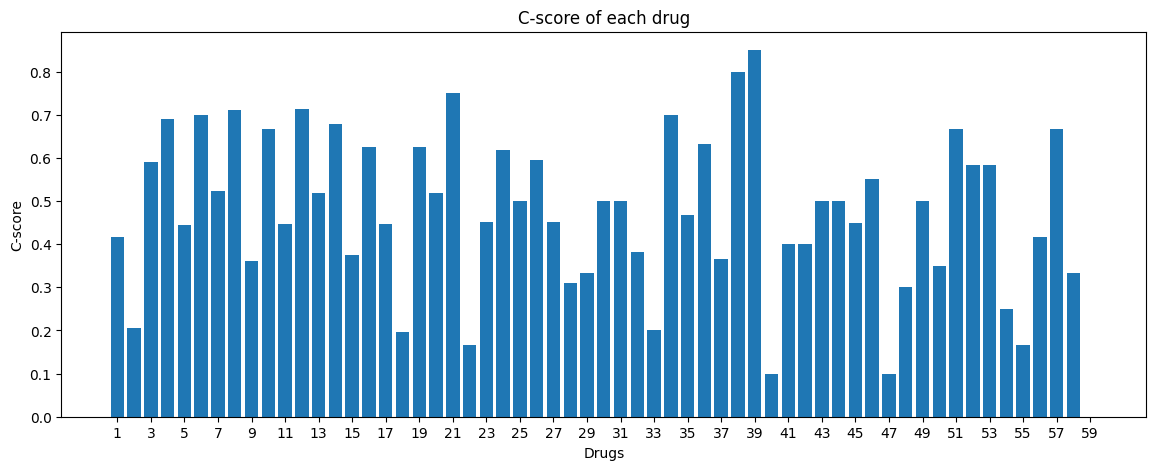

In [71]:
# Implement and run the requested cross-validation. Report and interpret its results.

# Splitting our drugs and proteins
pairs[['Drug', 'Protein']] = pairs[0].str.split(' ', expand=True)

# Creating integers for each unique drug type
pairs['Drug'] = pairs['Drug'].str[1:].astype(int) 
    
# Turning our dataframes into numpy arrays
X = inputs.to_numpy()
y = outputs.to_numpy()
groups = pairs['Drug'].to_numpy()

# Creating our model with splits for each drug
gkf = GroupKFold(n_splits=59)

# Our bioscientist used 10 nearest neighbors so I'll use them too
knn = KNeighborsRegressor(n_neighbors=10)

# Empty array for our results
drug_scores = []

# Standard split while keeping the groups in mind
for train, test in gkf.split(X, y, groups):
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]
    
    # Fitting our training data on the model
    knn.fit(X_train, y_train)
    
    # Creating some predictions
    pred_labels = knn.predict(X_test)
    
    # Calculating the c-index
    drug_scores.append(cindex(y_test,pred_labels))
  
# Taking our indexes for classifying each drug
indexes = np.arange(1, len(drug_scores)+1)

# Plotting our c-indexes
plt.figure(figsize=(14,5))
plt.xlabel("Drugs")
plt.ylabel("C-score")
plt.title("C-score of each drug")
plt.xticks(np.arange(1, len(drug_scores)+1, 2))
plt.bar(indexes, drug_scores)
plt.show()